In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import pandas as pd
import numpy as np

In [5]:
data=pd.read_csv("weatherAUS.csv")

In [7]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<Axes: xlabel='RainTomorrow', ylabel='count'>

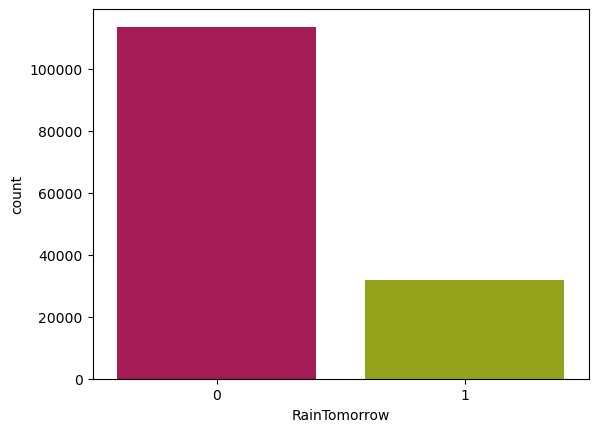

In [38]:
cols= ["#ba0552","#a4ba05"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

C:\Users\GKLAB_TAMIL\AppData\Local\Temp\ipykernel_2684\1012821133.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


<Axes: >

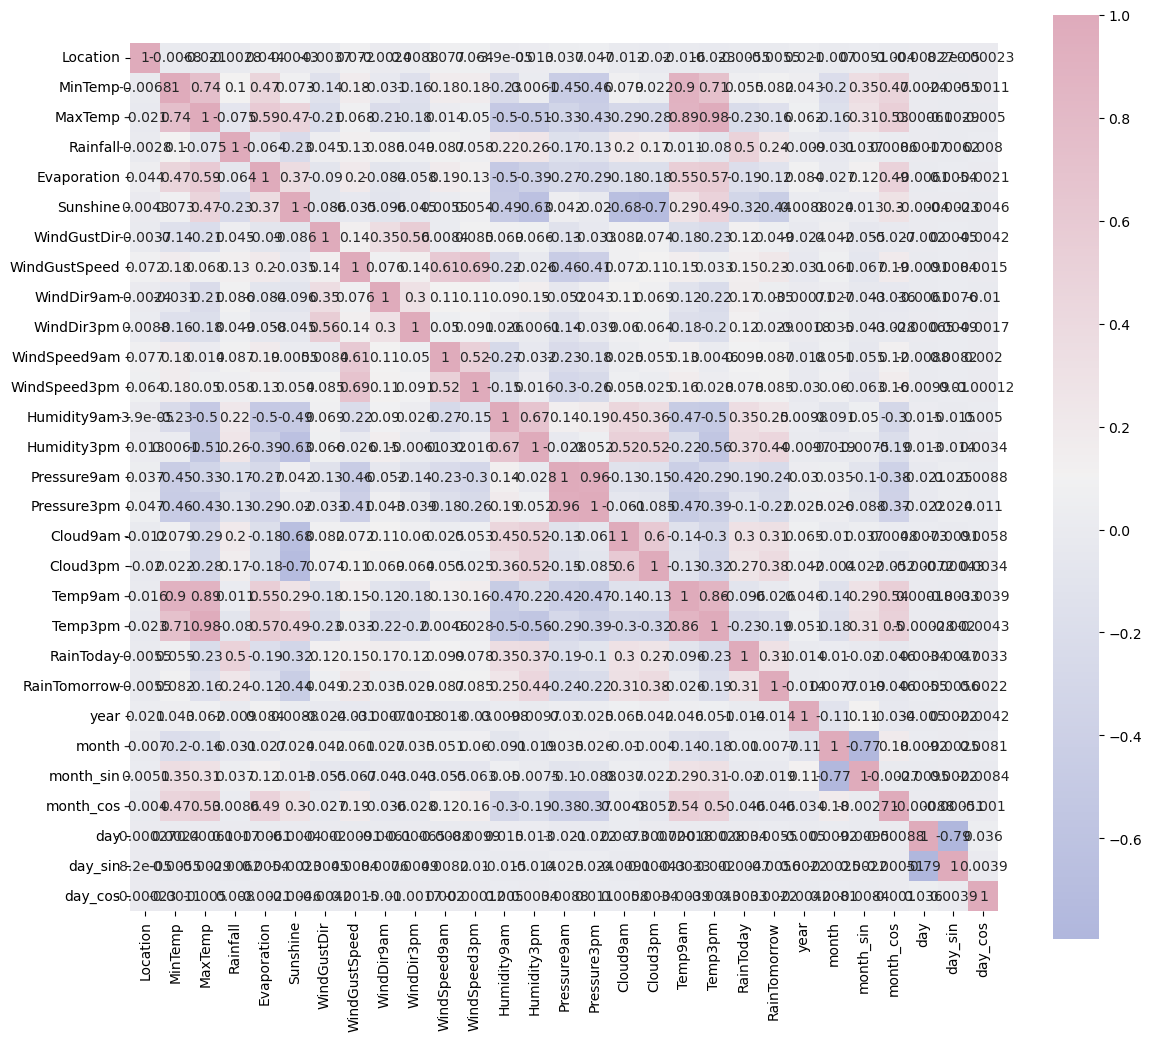

In [58]:
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(14,12))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [12]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

In [13]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

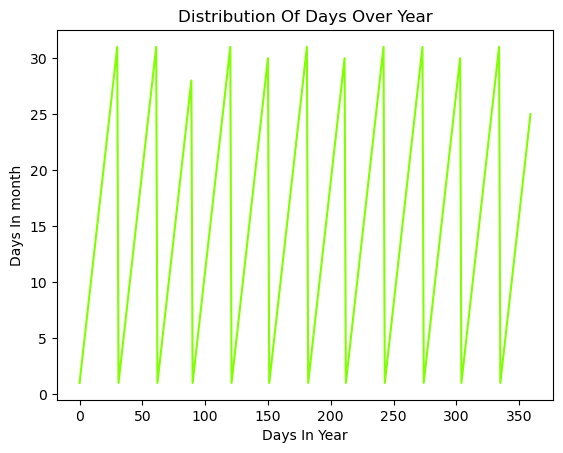

In [39]:
# roughly a year's span section 
section = data[:360] 
tm = section["day"].plot(color="#7fff00")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

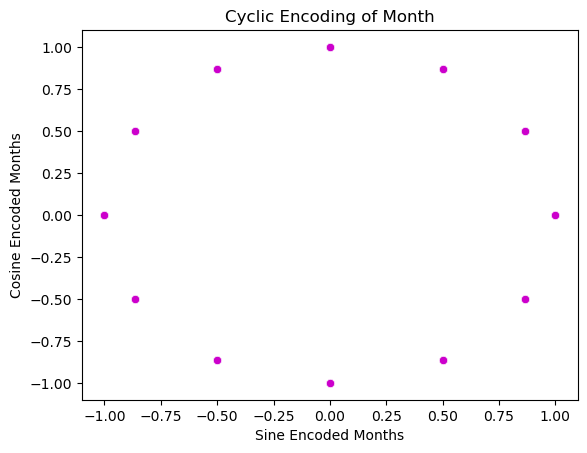

In [40]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#cc00cc")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

In [16]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [17]:
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [18]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [19]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [20]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int32         
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    145460 non-null  int32         
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     145460 non-null  int32         
 10  WindDir3pm     145460 non-null  int32         
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [21]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,143975.0,-3.790219e-16,1.000003,-3.234215,-0.717989,-0.030325,0.735483,3.392367
MaxTemp,144199.0,-1.387588e-16,1.000003,-3.936122,-0.747483,-0.087280,0.699345,3.494672
Rainfall,142199.0,6.875624e-17,1.000004,-0.278475,-0.278475,-0.278475,-0.184113,43.481692
Evaporation,82670.0,1.732738e-16,1.000006,-1.303922,-0.683942,-0.159343,0.460638,33.271926
Sunshine,75625.0,1.443165e-16,1.000007,-2.010636,-0.742625,0.208382,0.789554,1.819812
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,135197.0,-1.731198e-16,1.000004,-2.501301,-0.664013,-0.076081,0.585343,6.979105
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


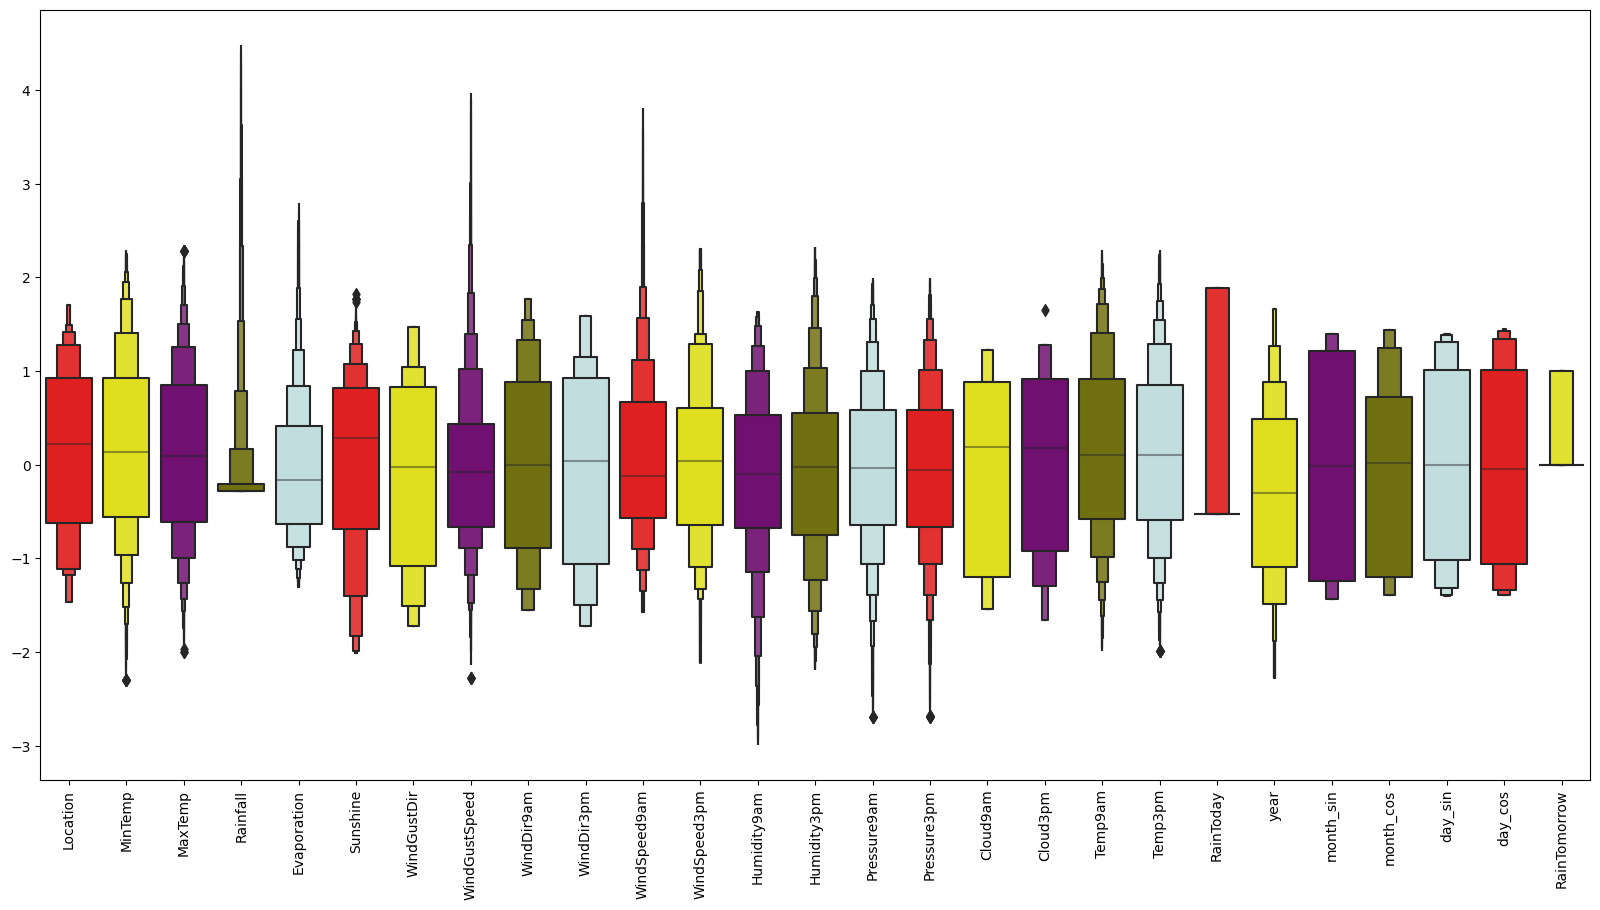

In [41]:
#Detecting outliers
#looking at the scaled features
colours = ["#ff0000", "#ffff00", "#800080", "#808000", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [23]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(52851, 27)

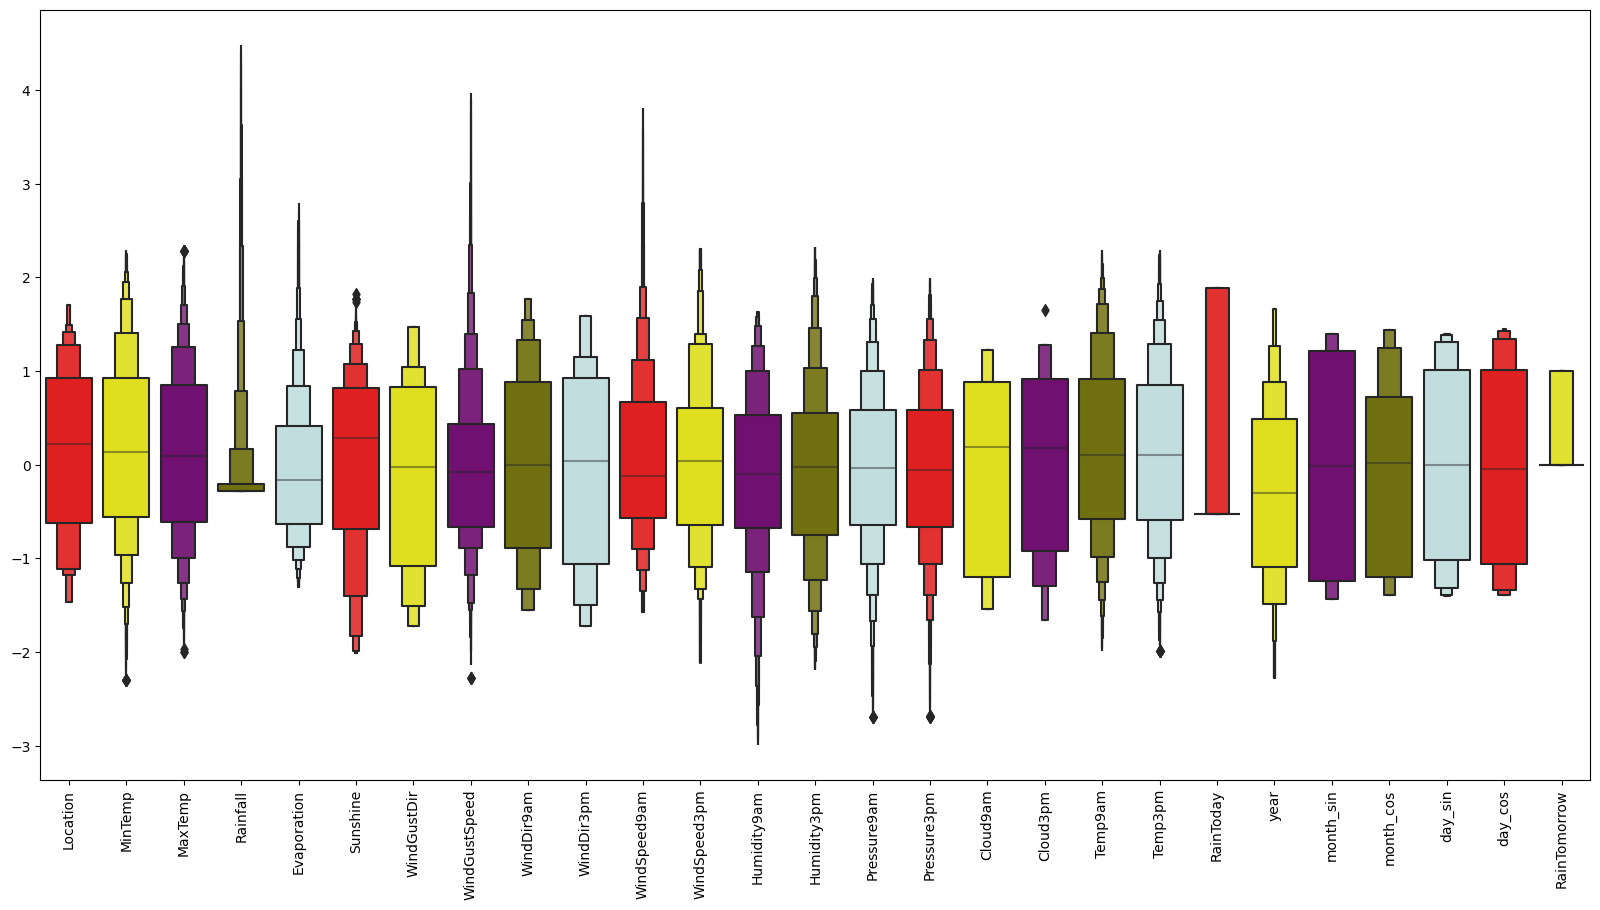

In [42]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [25]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(52851, 26)

In [26]:
X

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos
6049,-0.969420,0.891770,1.682626,-0.278475,1.557527,1.238641,0.619161,0.585343,-1.328556,0.925747,...,-0.847711,0.180150,1.480932,1.689093,-0.529795,-1.485514,0.692529,1.245139,0.278970,1.426023
6050,-0.969420,0.969914,0.797673,-0.278475,2.225199,1.423559,-0.019940,-0.223064,0.664436,0.485035,...,-1.194074,-1.290253,0.510018,0.766455,-0.529795,-1.485514,0.692529,1.245139,0.549587,1.339551
6052,-0.969420,1.126201,2.019750,-0.278475,1.271382,0.789554,-0.659041,0.438360,-0.442782,-0.396387,...,-1.194074,0.547751,1.804570,1.905337,-0.529795,-1.485514,0.692529,1.245139,1.012774,1.011221
6053,-0.969420,1.516919,2.132125,-0.278475,1.414455,1.212224,1.258262,-0.664013,1.550210,1.586813,...,-1.194074,0.180150,1.866215,2.006251,-0.529795,-1.485514,0.692529,1.245139,1.186382,0.782805
6056,-0.969420,1.735721,1.514063,-0.278475,1.032928,1.317891,0.619161,0.070902,0.221549,0.485035,...,-0.501347,-1.290253,1.234351,1.415185,-0.529795,-1.485514,0.692529,1.245139,1.396744,-0.044639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,-0.758577,1.110572,1.429782,-0.278475,0.126802,0.895221,-1.511176,-0.370047,0.442992,-0.837098,...,-1.540437,-1.290253,1.157294,1.530515,-0.529795,1.666978,-0.016425,-1.388032,-1.111661,-0.846162
142299,-0.758577,1.407518,1.317407,-0.278475,0.508329,0.261216,-1.724209,-0.223064,0.442992,0.264680,...,0.884105,-1.657854,1.203528,1.487266,-0.529795,1.666978,-0.016425,-1.388032,-1.261688,-0.601030
142300,-0.758577,1.329374,1.345501,-0.278475,0.031421,0.895221,-1.724209,-0.517030,-1.550000,1.146102,...,-1.540437,-1.657854,1.203528,1.501682,-0.529795,1.666978,-0.016425,-1.388032,-1.360192,-0.330159
142301,-0.758577,1.141830,1.205032,-0.278475,0.174493,0.789554,-1.298142,-1.031470,0.442992,-0.396387,...,-1.194074,-1.290253,1.203528,1.083612,-0.529795,1.666978,-0.016425,-1.388032,-1.403140,-0.044639


6049      0
6050      0
6052      0
6053      0
6056      0
         ..
142298    0
142299    0
142300    0
142301    0
142302    0
Name: RainTomorrow, Length: 52851, dtype: int32

In [29]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1057/1057 [==============================] - 3s 1ms/step - loss: 0.5319 - accuracy: 0.7856 - val_loss: 0.3843 - val_accuracy: 0.7875
Epoch 2/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.4177 - accuracy: 0.7859 - val_loss: 0.3731 - val_accuracy: 0.7875
Epoch 3/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.4099 - accuracy: 0.8051 - val_loss: 0.3673 - val_accuracy: 0.8506
Epoch 4/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.4026 - accuracy: 0.8229 - val_loss: 0.3616 - val_accuracy: 0.8518
Epoch 5/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.3989 - accuracy: 0.8294 - val_loss: 0.3564 - val_accuracy: 0.8508
Epoch 6/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.3873 - accuracy: 0.8345 - val_loss: 0.3523 - val_accuracy: 0.8517
Epoch 7/150
1057/1057 [==============================] - 1s 1ms/step - loss: 0.3807 - accuracy: 0.8327 - val_loss: 0.3487 - val_ac

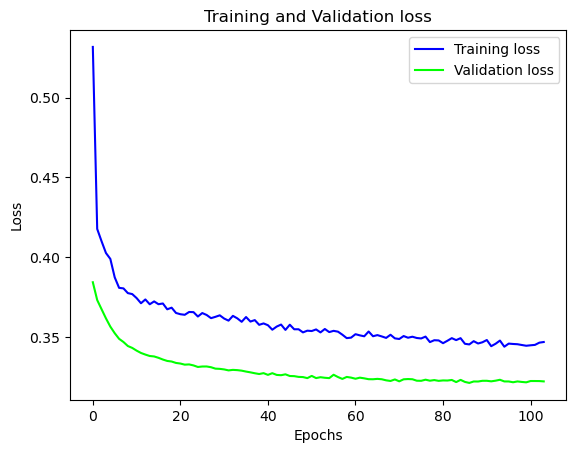

In [46]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#0000ff", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#00ff00", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

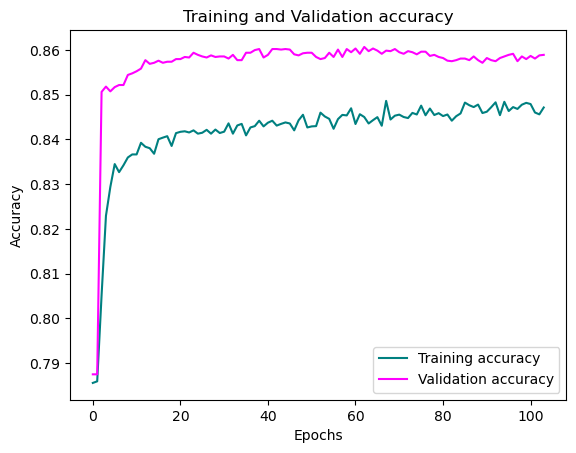

In [49]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#008080", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#ff00ff", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

331/331 [==============================] - 0s 682us/step


<Axes: >

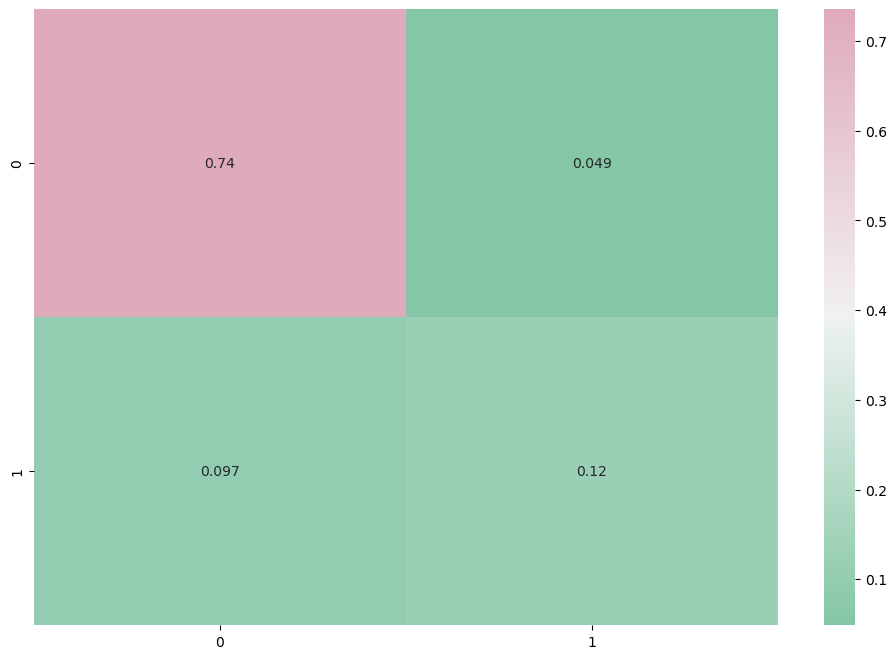

In [53]:
# confusion matrix
cmap1 = sns.diverging_palette(150,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':10})

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8289
           1       0.71      0.55      0.62      2282

    accuracy                           0.85     10571
   macro avg       0.80      0.74      0.76     10571
weighted avg       0.85      0.85      0.85     10571

